# Метод главных компонент
Суть метода главных компонент - сжать данные до меньшей размерности, как в t-SNE, оставив только важные закономерности в данных

![](https://habrastorage.org/getpro/habr/post_images/bb6/fe7/f06/bb6fe7f06e114bcc9c354a1cb025b966.png)

На картинке выше стрелочками указаны первые две главные компоненты. Чем длиннее, тем главнее :)

**Достоинства:**
Метод главных компонент похож на t-SNE, но:
* PCA работает НА ПОРЯДКИ быстрее t-SNE
* не требует меток классов (обучение без учителя, требует только X) !

**Недостатки:**
* при сжатии теряется "гипотеза компактности" и объекты часто смешиваются в кучу

**Область применения:**
* Визуализация больших данных
* Упрощение данных
* Кластеризация
* Поиск скрытых компонент в данных. Пример - тематическое моделирование и рекомендации

# Практика

**WARNING!!!** Код визуализации сложный и на практике ненужный, вникать не надо! Цель клетки ниже - визуализировать ирисы по первым трём признакам

[]

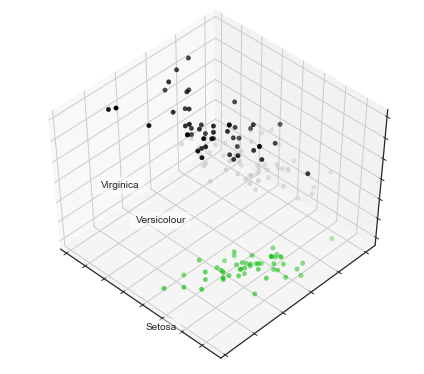

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

# Загрузим наши ириски
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Заведём красивую трёхмерную картинку
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Поменяем порядок цветов меток, чтобы они соответствовали правильному
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, cmap=plt.cm.spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

Теперь посмотрим, насколько PCA улучшит результаты для модели, которая в данном случае плохо справится с классификацией из-за того, что у неё не хватит сложности для описания данных. Код ниже должен быть Вам уже хорошо хнаком

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Выделим из наших данных валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

# Для примера возьмём неглубокое дерево решений
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.88889


Теперь попробуем сделать то же самое, но с данными, для которых мы снизили размерность до 2D с помощью PCA

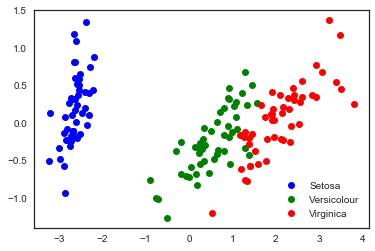

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Прогоним встроенный в sklearn PCA
pca = PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [4]:
from sklearn.model_selection import train_test_split

# Повторим то же самое разбиение на валидацию и тренировочную выборку.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.91111


Видно, что качество возросло незначительно, но для более сложных данных более высокой размерности, где данные не разбиваются тривиально вдоль одного признака, применение PCA может достаточно сильно улучшить качество работы деревьев решений и ансамблей на их основе. 

Посмотрим теперь на 2 главные компоненты в последнем PCA-представлении данных и на тот процент исходной дисперсии в даных, который они "объясняют".

In [5]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

1 component: 92.46% of initial variance
0.362 x sepal length (cm) + -0.082 x sepal width (cm) + 0.857 x petal length (cm) + 0.359 x petal width (cm)
2 component: 5.3% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.176 x petal length (cm) + -0.075 x petal width (cm)


# Набор данных по рукописным цифрам
Теперь возьмем набор данных по рукописным цифрам

In [6]:
digits = datasets.load_digits()pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection')
X = digits.data
y = digits.target

SyntaxError: invalid syntax (<ipython-input-6-f735ba946a24>, line 1)

Посмотрим, как выглядят эти цифры – посмотрим на первые десять. Картинки здесь представляются матрицей 8 x 8 (интенсивности белого цвета для каждого пикселя). Далее эта матрица "разворачивается" в вектор длины 64, получается признаковое описание объекта.

In [ ]:
# f, axes = plt.subplots(5, 2, sharey=True, figsize=(16,6))
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]));

Получается, размерность признакового пространства здесь – 64. Но давайте снизим размерность всего до 2 и увидим, что даже на глаз рукописные цифры неплохо разделяются на кластеры.

In [ ]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection')

Ну, правда, с t-SNE картинка получается еще лучше, поскольку у PCA ограничение – он находит только линейные комбинации исходных признаков. Зато даже на этом относительно небольшом наборе данных можно заметить, насколько t-SNE дольше работает.

In [ ]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных. В данном случае для этого достаточно выделить 21 главную компоненту, то есть снизить размерность с 64 признаков до 21.

In [ ]:
pca = PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

# Полезные ссылки
* https://habrahabr.ru/company/ods/blog/325654/